In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

import torch
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from CapsuleNet import CapsuleNetwork, CapsuleLoss, display_images
from utils import DICOMFineDataset, TransformDataset, TransformDatasetBalanced, TensorFolderDataset, find_overlapping_images

In [ ]:
# Definition if Data Augmentation is Applied and the folder to store the weights
data_augmentation = True
save_folder_base = "./data/fine"

In [ ]:
# Definition of the Data Folder and the initially set variables 
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten/nodule"
seed = 41

batch_size = 50
image_size = 80
classes = ["A", "B", "E", "G"]
train_ratio = 0.8

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

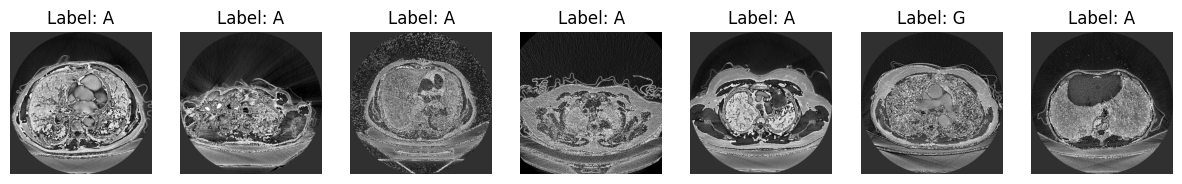

In [ ]:
# Creation of the training and the test transforms for the CapsNet Model
classes_dict = {value: index for index, value in enumerate(classes)}
train_transforms = None

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

if data_augmentation:
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),        # Rotate by up to ±15 degrees
        transforms.RandomResizedCrop((224, 224),      # Random crop and resize to simulate zooming
                        scale=(0.8, 1.2),  # Scale for zoom in/out
                        ratio=(0.9, 1.1)),
        transforms.RandomAffine(degrees=0, shear=10), # Apply random shear with ±10 degrees
        transform
    ])
else: 
    train_transforms = transform
# Visualization of different CT images from the Dataset with their corresponding labels
dataset = DICOMFineDataset(root_dir=BASE_DIR, classes=classes_dict)
dataset.visualize_images(num_images=7)

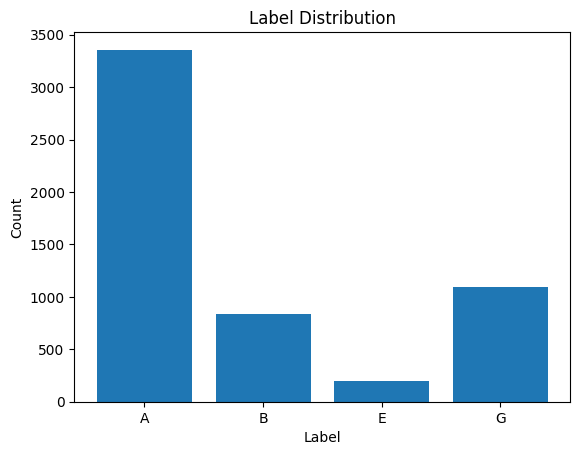

In [ ]:
# Visualization of the Label Distribution within the dataset
dataset.display_label_distribution()

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


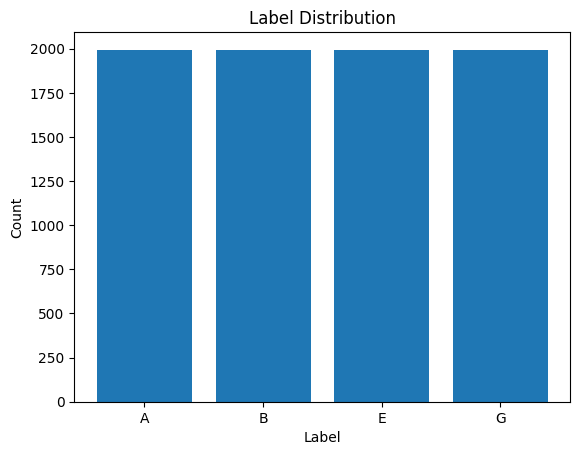

In [ ]:
# Rebalancing of the Dataset and visualization of the balanced label distribution
train_dataset_base = TensorFolderDataset(os.path.join(save_folder_base, "train"))
test_dataset_base = TensorFolderDataset(os.path.join(save_folder_base, "test"))

train_dataset = TransformDatasetBalanced(train_dataset_base, classes=classes_dict)
train_dataset.display_label_distribution()

In [ ]:
# Check for overlapping images in the training and test set. (The mentioned images were manually checked and do not overlap)
test_dataset = TransformDataset(test_dataset_base)

find_overlapping_images(train_dataset, test_dataset)

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Found 4 overlapping images
Train index: 1889, Test index: 100
Train index: 2872, Test index: 161
Train index: 1978, Test index: 538
Train index: 1657, Test index: 1052


[100, 161, 538, 1052]

In [ ]:
# Load the CapsNet Model
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=6400, bias=True)
      (5): Sigmoid()
    )
  )
)


In [ ]:
# Load the Datasets with applied transformations
train_dataset = TransformDatasetBalanced(train_dataset_base, classes=classes_dict, transform=transform)
test_dataset = TransformDataset(test_dataset_base, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Loading the Custom Loss Function for the CapsNet and the Optimizer
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [ ]:
# Execution of the Training Process for the CapsNet Model
n_epochs = 5
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)

Epoch: 1 	Training Loss: 7.32577562
Epoch: 1 	Training Loss: 3.57473350
Epoch: 1 	Training Loss: 3.49793792
Epoch: 1 	Training Loss: 3.43801761
Epoch: 1 	Training Loss: 3.34247518
Epoch: 1 	Training Loss: 3.25929642
Epoch: 1 	Training Loss: 3.15469670
Epoch: 1 	Training Loss: 2.99547720
Epoch: 1 	Training Loss: 2.84972739
Epoch: 1 	Training Loss: 2.74160123
Epoch: 1 	Training Loss: 2.58456516
Epoch: 1 	Training Loss: 2.43078542
Epoch: 1 	Training Loss: 2.23104930
Epoch: 1 	Training Loss: 2.12685847
Epoch: 1 	Training Loss: 1.99280572
Epoch: 1 	Training Loss: 1.89394891
Epoch: 1 	Training Loss: 1.84043837
Epoch: 1 	Training Loss: 1.76497841
Epoch: 1 	Training Loss: 1.71476710
Epoch: 1 	Training Loss: 1.70457375
Epoch: 1 	Training Loss: 1.67218912
Epoch: 1 	Training Loss: 1.64157283
Epoch: 1 	Training Loss: 1.63561738
Epoch: 1 	Training Loss: 1.62247682
Epoch: 1 	Training Loss: 1.61887908
Epoch: 1 	Training Loss: 1.59713197
Epoch: 1 	Training Loss: 1.54773378
Epoch: 1 	Training Loss: 1.5

Test Loss: 1.32114807

Test Accuracy of     0: 92.39% (631/683)
Test Accuracy of     1: 39.76% (66/166)
Test Accuracy of     2: 9.09% ( 4/44)
Test Accuracy of     3: 23.67% (49/207)

Test Accuracy (Overall): 68.18% (750/1100)


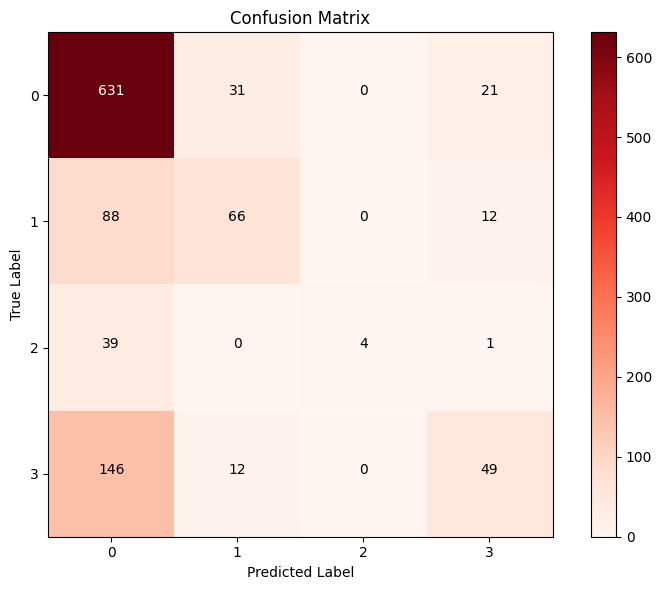

In [ ]:
# Evaluation Process of the CapsNet Model
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

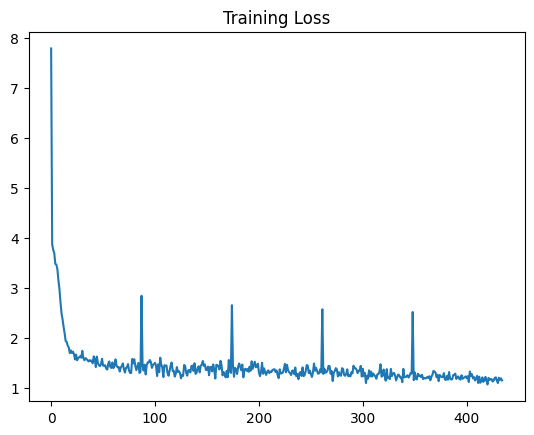

In [ ]:
# Visualization of the Training Loss for the CapsNet Model
plt.plot(losses)
plt.title("Training Loss")
plt.show()

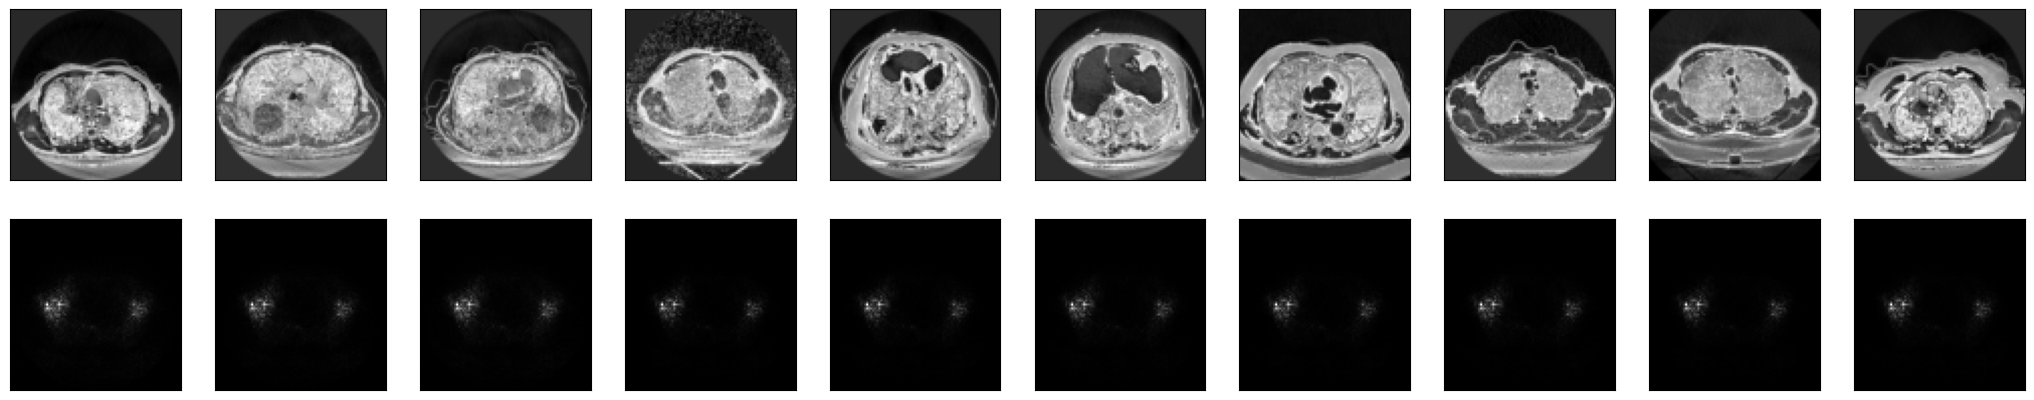

In [ ]:
# Visualization of the possible reconstructions of the CapsNet Model
display_images(images, reconstructions)